**Dhava Gautama**
<br>Klasifikasi emosi dalam tulisan. Data yang digunakan adalah data **Emotions dataset for NLP** yang bersumber dari **Kaggle** (https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?datasetId=605165)

In [1]:
# Import Library
import pandas as pd
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [5]:
# Load Data
df = pd.read_csv("/content/emosi.csv")
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
# Check Jumlah Emosi
df['emotion'].value_counts()

joy         6066
sadness     5216
anger       2434
fear        2149
love        1482
surprise     653
Name: emotion, dtype: int64

In [7]:
# Mengecek nilai kosong
df.isnull().values.any()

False

In [8]:
# Labeling Emosi
emotion = pd.get_dummies(df.emotion)
df_emotion = pd.concat([df, emotion], axis=1)
df_emotion = df_emotion.drop(columns='emotion')
df_emotion.head()

,text,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0


In [9]:
# Mengubah tipe data menjadi str dan numpy array 
text = df_emotion['text'].astype(str)
label = df_emotion[['anger', 'fear','joy','love','sadness','surprise']].values

In [14]:
# Split dataset (20% dari dataset sebagai validation)
emotion_train, emotion_test, label_train, label_test = train_test_split(text, label, test_size = 0.2)
print('Jumlah sample training:',len(emotion_train))
print('Jumlah sample test:',len(emotion_test))

Jumlah sample training: 14400
Jumlah sample test: 3600


In [15]:
# Tokenizer
tokenizer = Tokenizer(num_words=15212, oov_token='x')
tokenizer.fit_on_texts(emotion_train) 
tokenizer.fit_on_texts(emotion_test)
 
sequence_train = tokenizer.texts_to_sequences(emotion_train)
sequence_test = tokenizer.texts_to_sequences(emotion_test)
 
padded_train = pad_sequences(sequence_train) 
padded_test = pad_sequences(sequence_test)

In [16]:
# Gunakan model LSTM dengan Embedding
model = Sequential([
    Embedding(input_dim=15212, output_dim=64),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          973568    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,015,686
Trainable params: 1,015,686
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# Model di compile dengan menggunakan optimizer Adam
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [18]:
# Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi train dan validasi didapat telah mencapai nilai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [19]:
num_epochs = 20
history = model.fit(padded_train, label_train, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/20
450/450 - 19s - loss: 1.2633 - accuracy: 0.4983 - val_loss: 0.7320 - val_accuracy: 0.7289 - 19s/epoch - 43ms/step
Epoch 2/20
450/450 - 17s - loss: 0.4398 - accuracy: 0.8510 - val_loss: 0.3851 - val_accuracy: 0.8731 - 17s/epoch - 37ms/step
Epoch 3/20

Akurasi train dan validasi didapat telah mencapai nilai > 90%!
450/450 - 18s - loss: 0.1940 - accuracy: 0.9359 - val_loss: 0.3388 - val_accuracy: 0.9006 - 18s/epoch - 40ms/step


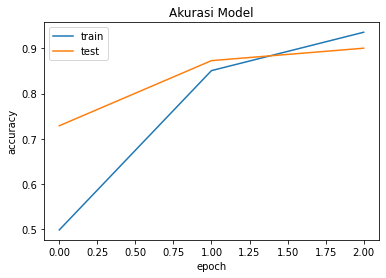

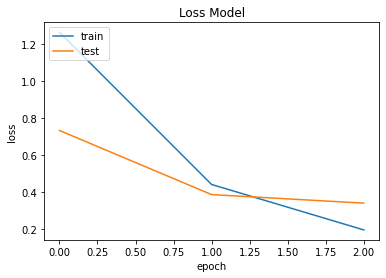

In [20]:
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()